# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO 
from io import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline
from scipy.interpolate import CubicSpline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "./clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where((data["loan_status"] == "Charged Off") | (data["loan_status"] == "Default"), True, False)

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [10]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [59]:
print(continuous_features)
print(discrete_features)
print(discrete_features_dummies)

print(ret_cols)

['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'int_rate', 'revol_util', 'cr_hist']
['emp_length', 'term', 'home_ownership', 'verification_status', 'grade', 'purpose']
['emp_length::10+ years', 'emp_length::2 years', 'emp_length::3 years', 'emp_length::4 years', 'emp_length::5 years', 'emp_length::6 years', 'emp_length::7 years', 'emp_length::8 years', 'emp_length::9 years', 'emp_length::< 1 year', 'emp_length::nan', 'term:: 60 months', 'term::nan', 'home_ownership::MORTGAGE', 'home_ownership::NONE', 'home_ownership::OTHER', 'home_ownership::OWN', 'home_ownership::RENT', 'home_ownership::nan', 'verification_status::Source Verified', 'verification_status::Verified', 'verification_status::nan', 'grade::B', 'grade::C', 'grade::D', 'grade::E', 'grade::F', 'grade::G', 'grade::nan', 'purpose::credit_card', 'purpose::debt_consolidation', 'purpose::educational', 'purpose::home_improvement', 'purpose::hou

In [71]:
## define your set of features to use in different models
your_features = [
'loan_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Random Classifier
Fit time: 0.03 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



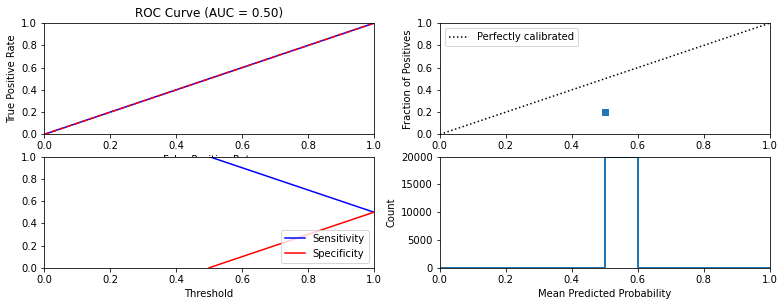


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.50236667]


In [72]:
from sklearn.dummy import DummyClassifier

# Prepare your data
# X, y = your_data, your_labels

# Create a DummyClassifier with the 'uniform' strategy to make random predictions
dummy_clf = DummyClassifier(strategy='uniform', random_state=default_seed)
dummy_clf = fit_classification(model=dummy_clf,
                        data_dict=data_dict,
                        model_name='Random Classifier',
                        random_state=default_seed,
                        output_to_file=True,
                        print_to_screen=True)

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 1.6 seconds
Optimal parameters:
{'var_smoothing': 1e-10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



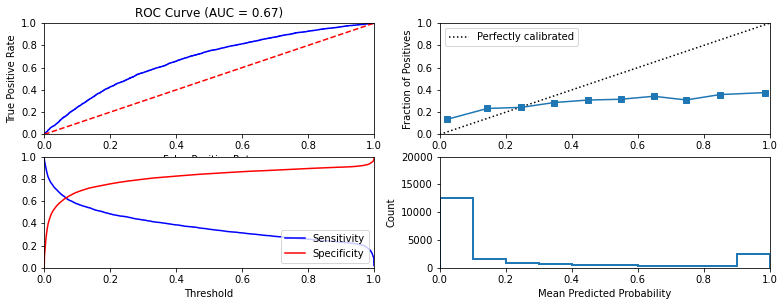


Similarity to LC grade ranking:  0.6781952239017416
Brier score: 0.21441284545868416
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.74163333 0.74163333 0.74163333 0.74163333 0.74163333]


In [14]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(model=gnb,
                        data_dict=data_dict,
                        cv_parameters={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]},
                        model_name='Gaussian Naive Bayes',
                        random_state=default_seed,
                        output_to_file=True,
                        print_to_screen=True)

### $l_1$ regularized logistic regression

  Model: Logistic Regression L1-regularized 
Fit time: 89.72 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.4605706176149526
Accuracy:  0.8
              precision    recall  f1-score   support

  No default     0.8111    0.9782    0.8868     16024
     Default     0.4822    0.0820    0.1402      3976

    accuracy                         0.8000     20000
   macro avg     0.6467    0.5301    0.5135     20000
weighted avg     0.7457    0.8000    0.7384     20000



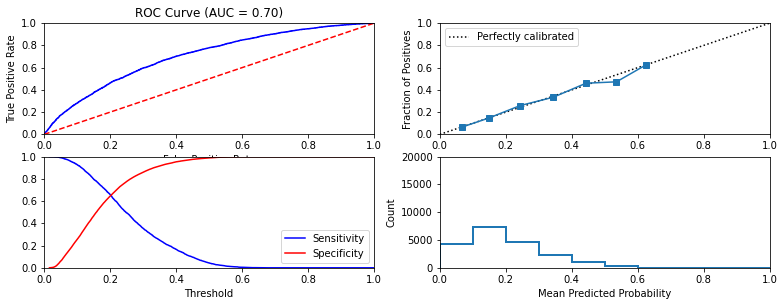


Similarity to LC grade ranking:  0.7177009387985286
Brier score: 0.14594160204401227
Were parameters on edge? : False
Score variations around CV search grid : 0.07484407484408044
[0.80113333 0.80113333 0.80113333 0.80113333 0.80106667 0.80116667
 0.8013     0.8015     0.80166667 0.8013     0.80113333]


In [15]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic =  LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = cv_parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

l1_logistic = fit_classification(model=l1_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L1-regularized ',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

### $l_2$ regularized logistic regression

  Model: Logistic Regression L2-regularized
Fit time: 12.77 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.48685588562601934
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8071    0.9881    0.8884     16024
     Default     0.5000    0.0480    0.0877      3976

    accuracy                         0.8012     20000
   macro avg     0.6535    0.5181    0.4881     20000
weighted avg     0.7460    0.8012    0.7292     20000



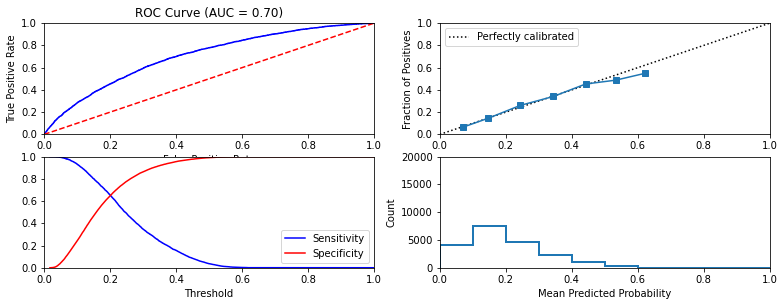


Similarity to LC grade ranking:  0.7074210995978958
Brier score: 0.1461006404946775
Were parameters on edge? : False
Score variations around CV search grid : 0.16618196925634507
[0.80113333 0.80113333 0.80113333 0.801      0.80176667 0.80176667
 0.80233333 0.80133333 0.8013     0.80116667 0.8012    ]


In [17]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic =  LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

l2_logistic = fit_classification(model=l2_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L2-regularized',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

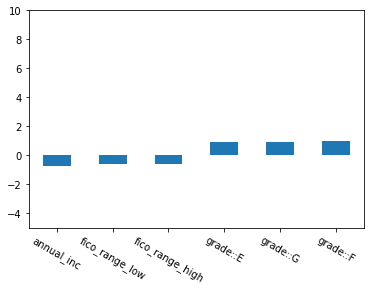

In [18]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

In [19]:
print(data.shape)
print(selected_features.shape)
print(sum(data["outcome"])/len(data))

(1081376, 34)
(55,)
0.1996530346521469


  Model: Decision Tree Classifier
Fit time: 1596.64 seconds
Optimal parameters:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.005, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



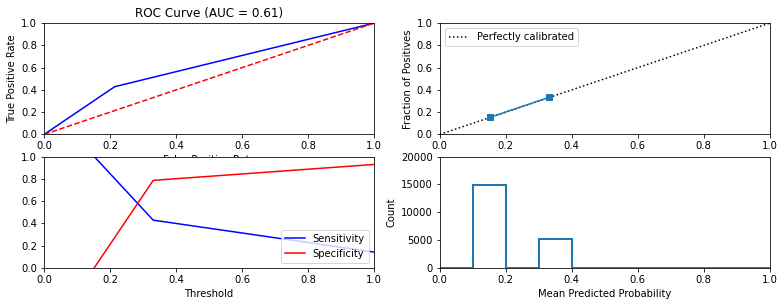


Similarity to LC grade ranking:  0.6768434354089615
Brier score: 0.153135354125818
Were parameters on edge? : True
Score variations around CV search grid : 13.435133560788874
[0.6979     0.7139     0.72863333 ... 0.80113333 0.80113333 0.80113333]


In [20]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier(random_state=default_seed)
cv_parameters = cv_parameters = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 80,90,100],
    'max_features': [None, 'sqrt', 'log2', 0.1, 0.25, 0.5, 0.75],
    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1],
}

decision_tree = fit_classification(model=decision_tree,
                                    data_dict=data_dict,
                                    cv_parameters=cv_parameters,
                                    model_name='Decision Tree Classifier',
                                    random_state=default_seed,
                                    output_to_file=True,
                                    print_to_screen=True)

### Random forest

  Model: Random Forest
Fit time: 28.46 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'max_samples': 0.25, 'min_impurity_decrease': 0.005, 'min_samples_split': 2, 'n_estimators': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



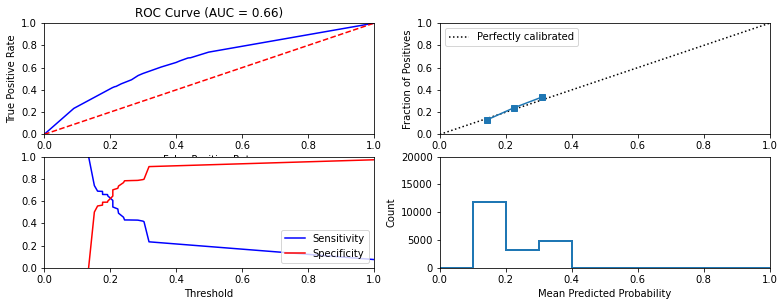


Similarity to LC grade ranking:  0.8232946413189874
Brier score: 0.15139641231303338
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80113333 0.80113333 0.80113333 0.80113333]


In [21]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(random_state=default_seed)
# cv_parameters = {
#     'n_estimators' : [10,25,50,75,100,150,200,300],
#     'bootstrap' :[True],
#     'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
#     'min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 80,90,100],
#     'max_features': [None, 'sqrt', 'log2', 0.1, 0.25, 0.5, 0.75],
#     'min_impurity_decrease': [0.0, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1],
#     'max_samples': [None, 0.1, 0.25, 0.5, 0.75,1.0]}

cv_parameters = {
    'n_estimators' : [10,50,100,150],
    'bootstrap' :[True],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': [None],
    'min_impurity_decrease': [0.005],
    'max_samples': [0.25]
}

random_forest = fit_classification(model=random_forest,
                                   data_dict=data_dict,
                                   cv_parameters=cv_parameters,
                                   model_name='Random Forest',
                                   random_state=default_seed,
                                   output_to_file=True,
                                   print_to_screen=True)

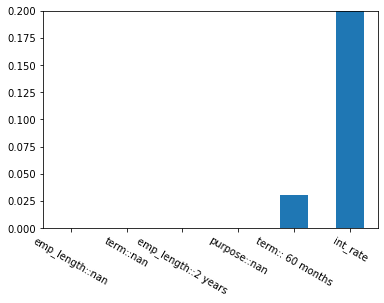

In [22]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi Layer Perceptron
Fit time: 11722.47 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}

Accuracy-maximizing threshold was: 0.46311036582667325
Accuracy:  0.80145
              precision    recall  f1-score   support

  No default     0.8060    0.9907    0.8888     16024
     Default     0.5083    0.0387    0.0720      3976

    accuracy                         0.8014     20000
   macro avg     0.6571    0.5147    0.4804     20000
weighted avg     0.7468    0.8014    0.7264     20000



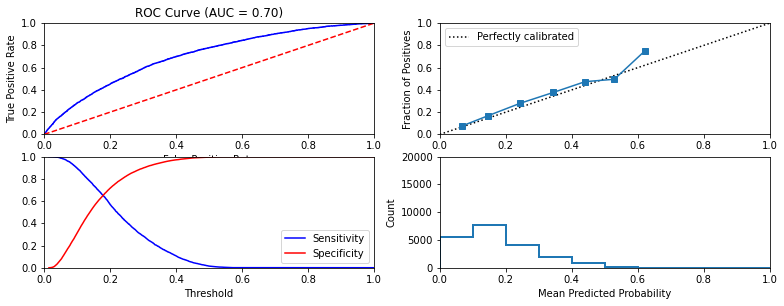


Similarity to LC grade ranking:  0.704288604827968
Brier score: 0.14675825765864087


In [23]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
# cv_parameters = {
#     'hidden_layer_sizes': [(10,10), (50,50), (100,)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'learning_rate_init': [0.001, 0.01, 0.1],
#     'alpha': [0.0001, 0.001, 0.01,1, 0.1]
# }
cv_parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'alpha': [0.0001, 0.001, 0.01]
}
mlp = fit_classification(mlp, data_dict,cv_parameters,model_name='Multi Layer Perceptron',
                         output_to_file=False,print_to_screen=True)


In [61]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model=GaussianNB(var_smoothing = 1e-10)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for Gaussian Naive Bayes for 100 different splits :",np.mean(scores))

Average test accuracy for Gaussian Naive Bayes for 100 different splits : 0.6572203859901908


In [63]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model=  LogisticRegression(penalty='l1', solver='liblinear', C = 1)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for L1 logistic regression for 100 different splits :",np.mean(scores))

Average test accuracy for L1 logistic regression for 100 different splits : 0.6932178646808355


In [64]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model=  LogisticRegression(penalty='l2', solver='lbfgs', C = 0.1)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for L2 logistic regression for 100 different splits :",np.mean(scores))

Average test accuracy for L2 logistic regression for 100 different splits : 0.6931297739965389


In [66]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model=  DecisionTreeClassifier(random_state=default_seed,max_depth= None, 
                                   max_features= None, 
                                   min_impurity_decrease= 0.005, min_samples_split= 2)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for Decision Tree classifier for 100 different splits :",np.mean(scores))

Average test accuracy for Decision Tree classifier for 100 different splits : 0.6187356487734516


In [68]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model = RandomForestClassifier(random_state=default_seed, bootstrap = True, max_depth= None, max_features= None, 
                max_samples= 0.25, min_impurity_decrease= 0.005, min_samples_split= 2, n_estimators= 10)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for Random Forest classifier for 100 different splits :",np.mean(scores))

Average test accuracy for Random Forest classifier for 100 different splits : 0.6470342279070384


In [69]:
scores=[]
for i in range(100):
    data_dict = prepare_data(feature_subset = final_features,random_state=i)
    X_train_i=data_dict["X_train"]
    y_train_i=data_dict["y_train"]
    X_test_i=data_dict["X_test"]
    y_test_i=data_dict["y_test"]
    # GIVE THE BEST HYPERPARAMETER FROM THE PREVIOUS OUTPUT
    model = MLPClassifier(activation = 'logistic', alpha= 0.01, hidden_layer_sizes= (100,), learning_rate_init= 0.001)
    model.fit(X_train_i,y_train_i)
    scores.append(roc_auc_score(y_test_i,model.predict_proba(X_test_i)[:,1]))

print("Average test accuracy for MLP for 100 different splits :",np.mean(scores))

Average test accuracy for MLP for 100 different splits : 0.6932131560374222


## Train and Test logistic regression model with features derived by LendingClub

  Model: Logistic Regression L1-regularized 
Fit time: 2.04 seconds
Optimal parameters:
{'C': 0.0001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



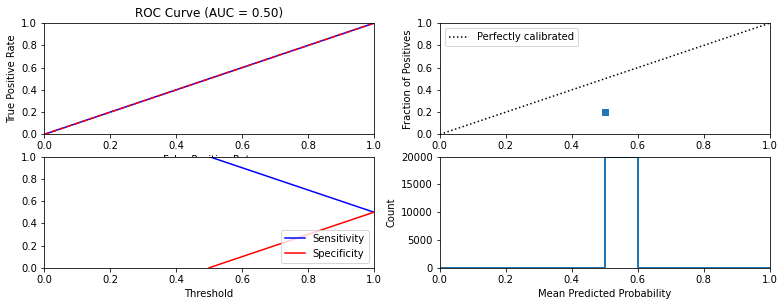


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : True
Score variations around CV search grid : 0.03328617791461729
[0.80113333 0.80113333 0.80113333 0.80113333 0.80113333 0.80113333
 0.80113333 0.80086667 0.80086667 0.8009     0.8009    ]


In [24]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'grade'
data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic =  LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters=  {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
lc1_only_logistic = fit_classification(model=lc1_only_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L1-regularized ',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

In [25]:
data_dict['X_train'].shape

(30000, 7)

  Model: Logistic Regression L2-regularized
Fit time: 2.36 seconds
Optimal parameters:
{'C': 0.0001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



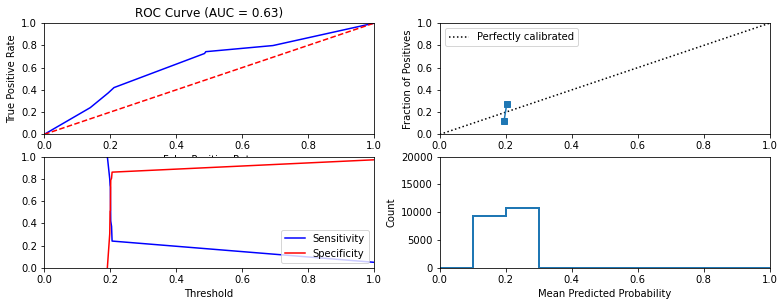


Similarity to LC grade ranking:  0.642416265805365
Brier score: 0.15864697837477615
Were parameters on edge? : True
Score variations around CV search grid : 0.03328617791461729
[0.80113333 0.80113333 0.80113333 0.80113333 0.80113333 0.80113333
 0.80113333 0.80113333 0.80086667 0.80086667 0.8009    ]


In [26]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
l2_logistic = fit_classification(model=lc2_only_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L2-regularized',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [27]:
data.head()


,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
0,164190449,15000.0,15000.0,60 months,23.05,D,7 years,MORTGAGE,63800.0,Source Verified,...,2020-02-01,2.037003,60,0.001793,0.052807,0.562917,1.800454,False,183.987351,True
1,163396715,12000.0,12000.0,36 months,7.56,A,10+ years,RENT,80000.0,Not Verified,...,2020-01-01,1.018501,36,0.000217,0.007670,0.565392,1.823593,False,129.941067,False
2,164160069,18825.0,18825.0,36 months,6.46,A,< 1 year,OWN,95000.0,Source Verified,...,2020-01-01,1.018501,36,0.000730,0.025803,0.566569,1.826705,False,87.985380,True
3,164174325,9075.0,9075.0,36 months,6.46,A,5 years,MORTGAGE,94000.0,Not Verified,...,2020-01-01,1.018501,36,0.000179,0.006337,0.565306,1.823364,False,177.942052,True
4,164107998,6000.0,6000.0,36 months,16.95,C,5 years,MORTGAGE,83200.0,Source Verified,...,2020-01-01,1.018501,36,0.005237,0.185114,0.576912,1.854049,False,135.986365,True


In [73]:
## define your set of features to use in different models
final_features = [
'loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Gaussian Naive Bayes
Fit time: 0.93 seconds
Optimal parameters:
{'var_smoothing': 1e-06}

Accuracy-maximizing threshold was: 0.9999999999996945
Accuracy:  0.80095
              precision    recall  f1-score   support

  No default     0.8012    0.9996    0.8895     16024
     Default     0.2222    0.0005    0.0010      3976

    accuracy                         0.8010     20000
   macro avg     0.5117    0.5000    0.4452     20000
weighted avg     0.6861    0.8010    0.7128     20000



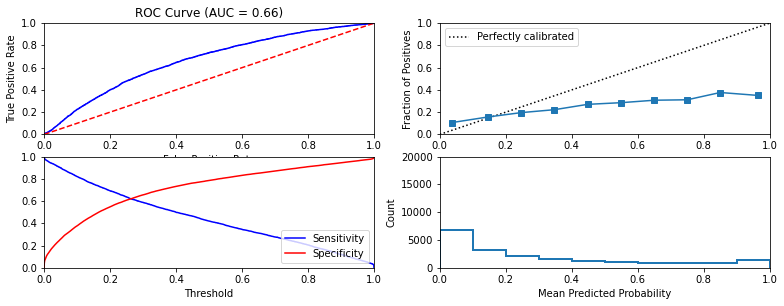


Similarity to LC grade ranking:  0.5387200456945855
Brier score: 0.21007466865929128
Were parameters on edge? : True
Score variations around CV search grid : 0.004733055660734049
[0.70423333 0.70423333 0.70423333 0.70423333 0.70426667]


In [29]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(model=gnb,
                        data_dict=data_dict,
                        cv_parameters={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]},
                        model_name='Gaussian Naive Bayes',
                        random_state=default_seed,
                        output_to_file=True,
                        print_to_screen=True)



  Model: Logistic Regression L1-regularized 
Fit time: 58.59 seconds
Optimal parameters:
{'C': 0.05}

Accuracy-maximizing threshold was: 0.48502185747196513
Accuracy:  0.80035
              precision    recall  f1-score   support

  No default     0.8064    0.9881    0.8880     16024
     Default     0.4767    0.0438    0.0802      3976

    accuracy                         0.8004     20000
   macro avg     0.6415    0.5159    0.4841     20000
weighted avg     0.7408    0.8004    0.7274     20000



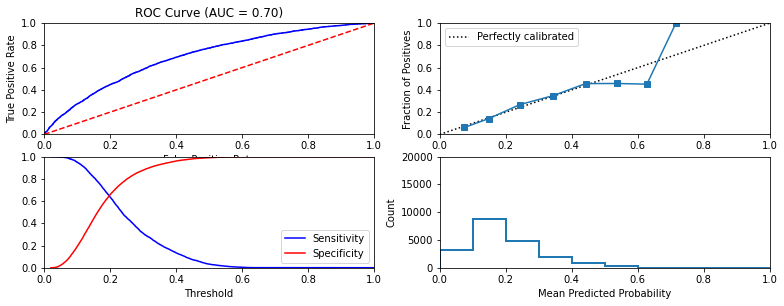


Similarity to LC grade ranking:  0.6610265055220242
Brier score: 0.14699498174963066
Were parameters on edge? : False
Score variations around CV search grid : 0.1745708466686148
[0.80113333 0.80113333 0.80113333 0.80113333 0.80056667 0.80196667
 0.80173333 0.8015     0.8014     0.8012     0.80116667]


In [30]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic =  LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = cv_parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

l1_logistic = fit_classification(model=l1_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L1-regularized ',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

  Model: Logistic Regression L2-regularized
Fit time: 10.09 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.45643224224179674
Accuracy:  0.80125
              precision    recall  f1-score   support

  No default     0.8061    0.9901    0.8887     16024
     Default     0.5016    0.0402    0.0745      3976

    accuracy                         0.8013     20000
   macro avg     0.6538    0.5152    0.4816     20000
weighted avg     0.7456    0.8013    0.7268     20000



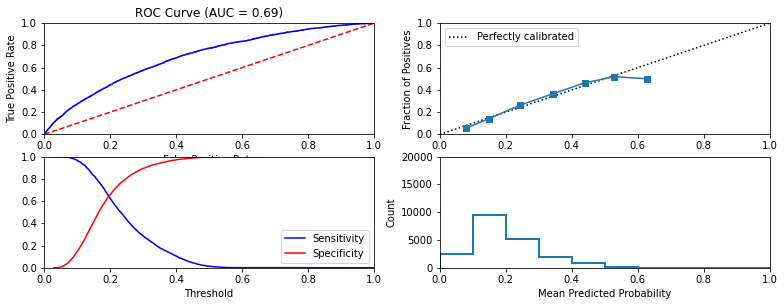


Similarity to LC grade ranking:  0.619306352648102
Brier score: 0.14733065040814727
Were parameters on edge? : False
Score variations around CV search grid : 0.11636605435958597
[0.80113333 0.80113333 0.80113333 0.8012     0.80206667 0.80196667
 0.802      0.8014     0.8014     0.80123333 0.80126667]


In [31]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic =  LogisticRegression(penalty='l2', solver='lbfgs')
cv_parameters = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

l2_logistic = fit_classification(model=l2_logistic,
                                data_dict=data_dict,
                                cv_parameters=cv_parameters,
                                model_name='Logistic Regression L2-regularized',
                                random_state=default_seed,
                                output_to_file=True,
                                print_to_screen=True)

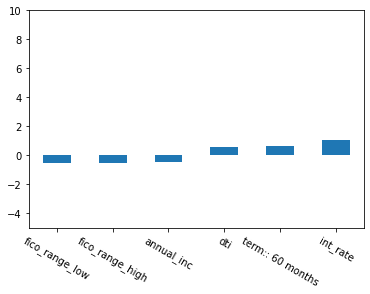

In [32]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

  Model: Decision Tree Classifier
Fit time: 1172.51 seconds
Optimal parameters:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.005, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



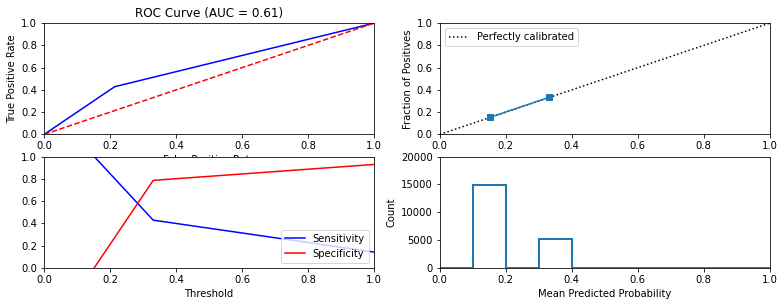


Similarity to LC grade ranking:  0.6768434354089615
Brier score: 0.153135354125818
Were parameters on edge? : True
Score variations around CV search grid : 13.501705916618121
[0.69606667 0.70873333 0.72493333 ... 0.80113333 0.80113333 0.80113333]


In [33]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier(random_state=default_seed)
cv_parameters = cv_parameters = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 80,90,100],
    'max_features': [None, 'sqrt', 'log2', 0.1, 0.25, 0.5, 0.75],
    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1],
}

decision_tree = fit_classification(model=decision_tree,
                                    data_dict=data_dict,
                                    cv_parameters=cv_parameters,
                                    model_name='Decision Tree Classifier',
                                    random_state=default_seed,
                                    output_to_file=True,
                                    print_to_screen=True)

  Model: Random Forest
Fit time: 27.8 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'max_samples': 0.25, 'min_impurity_decrease': 0.005, 'min_samples_split': 2, 'n_estimators': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



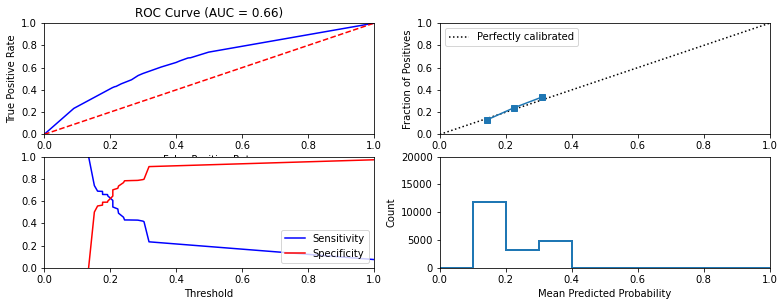


Similarity to LC grade ranking:  0.8232946413189874
Brier score: 0.15139641231303338
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80113333 0.80113333 0.80113333 0.80113333]


In [55]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(random_state=default_seed)
# cv_parameters = {
#     'n_estimators' : [10,25,50,75,100,150,200,300],
#     'bootstrap' :[True],
#     'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40],
#     'min_samples_split': [2, 10, 20, 30, 40, 50, 60, 70, 80,90,100],
#     'max_features': [None, 'sqrt', 'log2', 0.1, 0.25, 0.5, 0.75],
#     'min_impurity_decrease': [0.0, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1],
#     'max_samples': [None, 0.1, 0.25, 0.5, 0.75,1.0]}

cv_parameters = {
    'n_estimators' : [10,50,100,150],
    'bootstrap' :[True],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': [None],
    'min_impurity_decrease': [0.005],
    'max_samples': [0.25]
}

random_forest = fit_classification(model=random_forest,
                                   data_dict=data_dict,
                                   cv_parameters=cv_parameters,
                                   model_name='Random Forest',
                                   random_state=default_seed,
                                   output_to_file=True,
                                   print_to_screen=True)

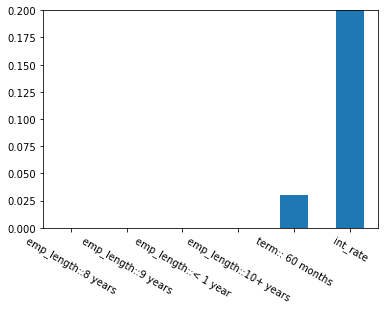

In [35]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

## Time stability test of YOURMODEL

In [36]:
data.groupby(pd.to_datetime(data['issue_d']).dt.year)['id'].count()[-3:].sum()/data.groupby(pd.to_datetime(data['issue_d']).dt.year)['id'].count().sum()

0.24988903027254164

In [37]:
data.groupby(pd.to_datetime(data['issue_d']).dt.year)['id'].count()[-3:].sum()

270224

In [38]:
data["issue_d"].dtype

dtype('O')

  Model: Random Forest
Fit time: 3.2 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'max_samples': 0.25, 'min_impurity_decrease': 0.005, 'min_samples_split': 2, 'n_estimators': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7823333333333333
              precision    recall  f1-score   support

  No default     0.7823    1.0000    0.8779      2347
     Default     0.0000    0.0000    0.0000       653

    accuracy                         0.7823      3000
   macro avg     0.3912    0.5000    0.4389      3000
weighted avg     0.6120    0.7823    0.6868      3000



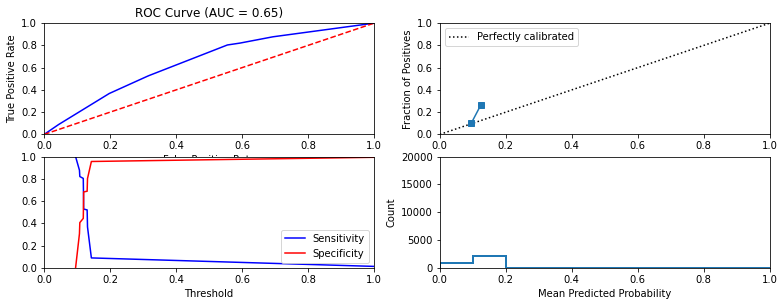


Similarity to LC grade ranking:  0.5948643136441721
Brier score: 0.1780745452709019
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.88414286 0.88414286 0.88414286 0.88414286]


In [77]:
## Define the time window of your train and test data

start_date_train = datetime.datetime.strptime("2010-01-01" , '%Y-%m-%d').date()
end_date_train =  datetime.datetime.strptime("2010-12-31" , '%Y-%m-%d').date()
start_date_test =  datetime.datetime.strptime("2018-01-01" , '%Y-%m-%d').date()
end_date_test = datetime.datetime.strptime("2018-12-31" , '%Y-%m-%d').date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 3000, feature_subset = final_features)


random_forest = RandomForestClassifier(random_state=default_seed)

cv_parameters = {
    'n_estimators' : [10,50,100,150],
    'bootstrap' :[True],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': [None],
    'min_impurity_decrease': [0.005],
    'max_samples': [0.25]
}

random_forest = fit_classification(model=random_forest,
                                   data_dict=data_dict_test,
                                   cv_parameters=cv_parameters,
                                   model_name='Random Forest',
                                   random_state=default_seed,
                                   output_to_file=True,
                                   print_to_screen=True)



  Model: Random Forest
Fit time: 4.06 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'max_samples': 0.25, 'min_impurity_decrease': 0.005, 'min_samples_split': 2, 'n_estimators': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7866666666666666
              precision    recall  f1-score   support

  No default     0.7867    1.0000    0.8806      2360
     Default     0.0000    0.0000    0.0000       640

    accuracy                         0.7867      3000
   macro avg     0.3933    0.5000    0.4403      3000
weighted avg     0.6188    0.7867    0.6927      3000



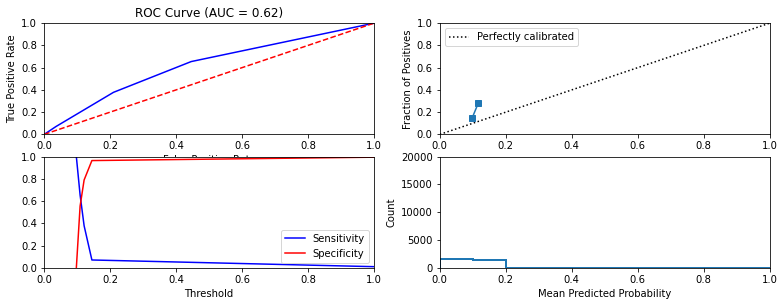


Similarity to LC grade ranking:  0.9149878324543382
Brier score: 0.17750102115477823
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.88742857 0.88742857 0.88742857 0.88742857]


In [78]:
## Define the time window of your train and test data

start_date_train = datetime.datetime.strptime("2017-01-01" , '%Y-%m-%d').date()
end_date_train =  datetime.datetime.strptime("2017-12-31" , '%Y-%m-%d').date()
start_date_test =  datetime.datetime.strptime("2018-01-01" , '%Y-%m-%d').date()
end_date_test = datetime.datetime.strptime("2018-12-31" , '%Y-%m-%d').date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 3000, feature_subset = final_features)


random_forest = RandomForestClassifier(random_state=default_seed)

cv_parameters = {
    'n_estimators' : [10,50,100,150],
    'bootstrap' :[True],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': [None],
    'min_impurity_decrease': [0.005],
    'max_samples': [0.25]
}

random_forest = fit_classification(model=random_forest,
                                   data_dict=data_dict_test,
                                   cv_parameters=cv_parameters,
                                   model_name='Random Forest',
                                   random_state=default_seed,
                                   output_to_file=True,
                                   print_to_screen=True)



  Model: XGBoost
Fit time: 19288.62 seconds
Optimal parameters:
{'colsample_bytree': 0.75, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.5}

Accuracy-maximizing threshold was: 0.4186105
Accuracy:  0.8124285714285714
              precision    recall  f1-score   support

  No default     0.8370    0.9599    0.8942      5781
     Default     0.3730    0.1132    0.1737      1219

    accuracy                         0.8124      7000
   macro avg     0.6050    0.5365    0.5340      7000
weighted avg     0.7562    0.8124    0.7687      7000



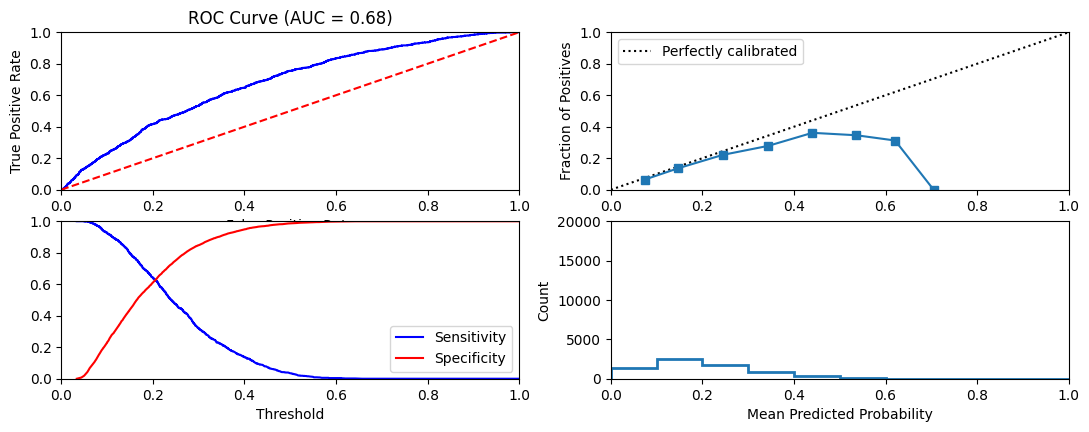


Similarity to LC grade ranking:  0.6616699391573095
Brier score: 0.13783851706505706
Were parameters on edge? : True
Score variations around CV search grid : 2.7743098904147496
[0.79988889 0.79988889 0.79988889 ... 0.78555556 0.78144444 0.78144444]


In [74]:
import xgboost as xgb

# Create an XGB classifier object
xgb_classifier = xgb.XGBClassifier(random_state=default_seed)

# Define a dictionary containing the cross-validation parameters
cv_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.5],
    'colsample_bytree': [0.5, 0.75, 1.0],
}

# Call the fit_classification() function with the appropriate parameters
xgb_model = fit_classification(model=xgb_classifier,
                               data_dict=data_dict_test,
                               cv_parameters=cv_parameters,
                               model_name='XGBoost',
                               random_state=default_seed,
                               output_to_file=True,
                               print_to_screen=True)


## Train and test YOURMODEL on the original data

  Model: Random Forest
Fit time: 26.68 seconds
Optimal parameters:
{'bootstrap': True, 'max_depth': None, 'max_features': None, 'max_samples': 0.25, 'min_impurity_decrease': 0.005, 'min_samples_split': 2, 'n_estimators': 10}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8012
              precision    recall  f1-score   support

  No default     0.8012    1.0000    0.8896     16024
     Default     0.0000    0.0000    0.0000      3976

    accuracy                         0.8012     20000
   macro avg     0.4006    0.5000    0.4448     20000
weighted avg     0.6419    0.8012    0.7128     20000



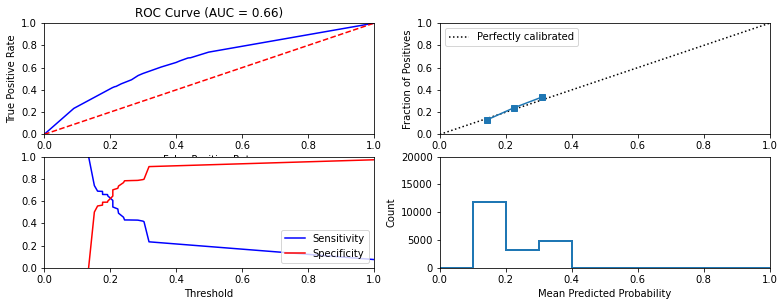


Similarity to LC grade ranking:  0.8232946413189874
Brier score: 0.15139641231303338
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80113333 0.80113333 0.80113333 0.80113333]


{'model': RandomForestClassifier(max_features=None, max_samples=0.25,
                        min_impurity_decrease=0.005, n_estimators=10,
                        random_state=1),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.30268909, 0.13469629, 0.19295033, ..., 0.19295033, 0.13469629,
        0.17679798])}

In [52]:
all_features = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership','annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title','zip_code', 'addr_state', 'dti', 'total_pymnt', 'delinq_2yrs', 'earliest_cr_line',
'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high',
'fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
'application_type', 'revol_bal', 'revol_util', 'recoveries']
data_dict = prepare_data(feature_subset = all_features)

## Train and test YOURMODEL using this data

# WILL PROBABLY NEED TO CHANGE THIS MODEL
rf = RandomForestClassifier(random_state=default_seed)

cvparamList = {
    'n_estimators' : [10,50,100,150],
    'bootstrap' :[True],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': [None],
    'min_impurity_decrease': [0.005],
    'max_samples': [0.25]
}

fit_classification(model=rf,data_dict=data_dict,
                                   cv_parameters=cvparamList,
                                   model_name='Random Forest',
                                   random_state=default_seed,
                                   output_to_file=True,
                                   print_to_screen=True)

# cvparamList = [x*2 for x in range(data.shape[1])]
# cvparamList.append(None)
# cv_parameters = {'max_depth': cvparamList}

# dt = DecisionTreeClassifier()
# fit_classification(dt,data_dict, cv_parameters,model_name='Decision Tree')


## Test regression models

In [40]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        print(ret_col)

        # print(data.loc[filter_train, ret_col])
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [41]:
data_dict["X_train"].shape

(30000, 48)

### $l_1$ regularized linear regression

In [42]:
## First, trying l1 regularized linear regression with hyper-parameters

from sklearn.linear_model import Lasso
cv_parameters = {
    'alpha': np.logspace(-4, 1, 6)
}

lasso_model = Lasso()

model_name = "Lasso Regression"

# Call the fit_regression function
reg_lasso = fit_regression(model=lasso_model, data_dict=data_dict, cv_parameters=cv_parameters, model_name=model_name)


ret_PESS
  Model: Lasso Regression  Return column: ret_PESS
Fit time: 26.89 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.03943372727730354
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -240.98193046644155
All test scores : [-0.01159498 -0.02752269 -0.03953679 -0.03953679 -0.03953679 -0.03953679]
ret_OPT
  Model: Lasso Regression  Return column: ret_OPT
Fit time: 33.79 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.022349139592873102
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 278.8535474657161
All test scores : [ 0.00580081 -0.00361266 -0.01037496 -0.01037496 -0.01037496 -0.01037496]
ret_INTa
  Model: Lasso Regression  Return column: ret_INTa
Fit time: 38.59 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.04590374629906013
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 121.40909006301875
All test scor

### $l_2$ regularized linear regressor

In [43]:
## trying l2 regularized linear regression with hyper-parameters
from sklearn.linear_model import Ridge
cv_parameters = {
    'alpha': np.logspace(-4, 1, 6)
}

ridge_model = Ridge()

model_name = "Ridge Regression"

# Call the fit_regression function
reg_ridge = fit_regression(model=ridge_model, data_dict=data_dict, cv_parameters=cv_parameters, model_name=model_name)


ret_PESS
  Model: Ridge Regression  Return column: ret_PESS
Fit time: 0.69 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: 0.04013832365653891
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.9044519811991347
All test scores : [-0.01133323 -0.01133535 -0.01133302 -0.01130862 -0.01120559 -0.01112351]
ret_OPT
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 0.85 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: 0.022942250222890204
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 4.296401349888964
All test scores : [0.00546225 0.00546875 0.00547221 0.0054963  0.00561087 0.00570747]
ret_INTa
  Model: Ridge Regression  Return column: ret_INTa
Fit time: 0.77 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: 0.046052520539923036
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.8906203451203547
All test scores : [0.031215

### Multi-layer perceptron regressor

In [44]:
## trying multi-layer perceptron regression with hyper-parameters

from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(random_state=default_seed,solver='adam',learning_rate='constant')

# Define the hyperparameters to optimize using cross-validation
cv_parameters = {
    'hidden_layer_sizes': [(10,), (50,50)],
    'activation': ['logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1]
    }


reg_mlp = fit_regression(model = mlp_model, data_dict= data_dict,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = "MLP Regressor",
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True)

ret_PESS
  Model: MLP Regressor  Return column: ret_PESS
Fit time: 58.16 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}

Testing r2 score: 0.03949738069747355
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 945.7076234038603
All test scores : [-0.02532798 -0.03499739 -0.00564384  0.00860272 -0.07275383 -0.00154256]
ret_OPT
  Model: MLP Regressor  Return column: ret_OPT
Fit time: 60.17 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}

Testing r2 score: 0.010488550370333027
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 527.8857744491416
All test scores : [-0.00259105 -0.02542251 -0.00890724  0.00594143 -0.02008125 -0.00092688]
ret_INTa
  Model: MLP Regressor  Return column: ret_INTa
Fit time: 74.35 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes':

### Random forest regressor

In [45]:
## trying random forest regression with hyper-parameters

from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(random_state=default_seed)

# Define hyperparameters to be tuned
cv_parameters = {
    'n_estimators': [10,50,100,150],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}

model_name = "Random Forest Regressor"

reg_rf = fit_regression(model = reg_rf, data_dict= data_dict,
                      cv_parameters = cv_parameters,
                      separate = False, 
                      model_name = model_name,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True )

ret_PESS
  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 673.23 seconds
Optimal parameters:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Testing r2 score: 0.0343663701807676
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -361.575116623546
All test scores : [-0.12749952 -0.04419631 -0.03229759 -0.0276227 ]
ret_OPT
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 668.95 seconds
Optimal parameters:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Testing r2 score: 0.006839979119483308
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -663.9540423810339
All test scores : [-0.12699169 -0.03704576 -0.01941059 -0.01662295]
ret_INTa
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 654.3 seconds
Optimal parameters:
{'max_depth': None, 

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [47]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = num_loans

            ## Find the average return for these loans
            ret_test = data_test[ret_col].iloc[:num_loans].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[:num_loans]

            ## Find the average return for these loans
            ret_test =  pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [49]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict=data_dict,classifier=None,regressor=None,
                              strategy = test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: -0.0033487895710861567
ret_OPT: 0.03696126237833046
ret_INTa: 0.4154103482654324
ret_INTb: 1.2638347895926758


In [56]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict=data_dict, classifier=random_forest,
                             regressor=None,strategy=test_strategy,num_loans = 1000, random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.01807470428073583
ret_OPT: 0.04363484942793374
ret_INTa: 0.41647524602330244
ret_INTb: 1.2569719525143639


In [53]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict=data_dict,classifier=None,
                             regressor=reg_rf,strategy=test_strategy,num_loans = 1000,random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.025822308646065658
ret_OPT: 0.03957188166939146
ret_INTa: 0.4145379947842627
ret_INTb: 1.2601514001855478


In [57]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
from sklearn.linear_model import Ridge
cv_parameters = {
    'n_estimators': [10,50,100,150],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None]
}

reg_rf_drb = RandomForestRegressor(random_state=default_seed)
model_name = "Random Forest Regressor"

reg_separate = fit_regression(model=reg_rf_drb, data_dict=data_dict, cv_parameters=cv_parameters,
                              separate = True, model_name=model_name)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict=data_dict, classifier=random_forest,
                             regressor=reg_separate, strategy=test_strategy, num_loans = 1000, random_state = default_seed,
                        output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

ret_PESS
  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 640.66 seconds
Optimal parameters:
model_0: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150} model_1 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Testing r2 scores:
model_0: 0.13051833883311303
model_1: 0.15007979823376671
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -82.59233621296465
All test scores : [-0.22889597 -0.14026768 -0.13057324 -0.12535903]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -248.76349897216127
All test scores : [-0.11530262 -0.04303475 -0.03472609 -0.0330604 ]
ret_OPT
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 637.38 seconds
Optimal parameters:
model_0: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_est

## Sensitivity test of portfolio size

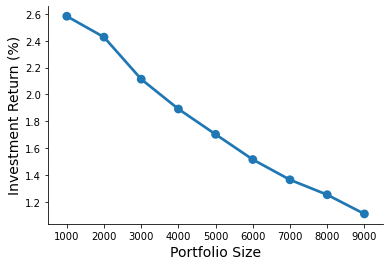

In [58]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

test_strategy = 'Return-based' 
## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict=data_dict,classifier=None,
                             regressor=reg_rf,strategy=test_strategy,num_loans = num_loans,random_state = default_seed,
                        output_to_file = True)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()